In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [61]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y.reshape((-1,1)) - tx@w
    return np.squeeze(e.T @ e) / (2*len(y))

In [79]:
def compute_rmse(y, tx, w):
    e = y - tx@w
    mse = np.squeeze(e.T @ e) / (2*len(y))
    return np.sqrt(2*mse)

In [62]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(tx.T @ tx, tx.T @ y)
    e = y - tx@w
    mse = np.squeeze(e.T @ e) / (2*len(y))
    return mse, w

In [66]:
def least_squares_gd(y, tx):
    def compute_gradient(y, tx, w):
        """Compute the gradient."""
        return - tx.T @ (y.reshape((-1,1)) - tx@w) / len(y)
    
    def gradient_descent(y, tx, initial_w, max_iters, gamma):
        """Gradient descent algorithm."""
        # Define parameters to store w and loss
        ws = [initial_w]
        w = initial_w
        for n_iter in range(max_iters):
            grad = compute_gradient(y, tx, w.reshape((-1,1)))
            w = w - gamma * np.squeeze(grad)
        loss = compute_loss(y, tx, w.reshape((-1,1)))

        return loss, ws
    
    return gradient_descent(y, tx, np.zeros((tx.shape[1],)), max_iters=100, gamma=0.7)

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [67]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    mse_ls, w_ls = least_squares(y, tx)
    mse_ls_gd, w_ls_gd = least_squares_gd(y, tx) 
    print(f"MSE loss: LS: {mse_ls:.3f}; LSGD: {mse_ls_gd:.3f}")

Test it here

In [68]:
test_your_least_squares()

MSE loss: LS: 15.386; LSGD: 15.386


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [69]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [71]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    res = np.zeros((len(x), degree+1))
    for i, xn in enumerate(x):
        for d in range(degree+1):
            res[i][d] = xn**d
    return res

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [75]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        tx = build_poly(x, degree)
        loss, w  = least_squares(y, tx)
        rmse = np.sqrt(2*loss)

        print(f"Processing {ind+1}th experiment, degree={degree}, rmse={rmse}")
        # plot fit
        plot_fitted_curve(y, x, w, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.4718760796342188
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.24965870360907347
Processing 4th experiment, degree=12, rmse=0.24337224835787005


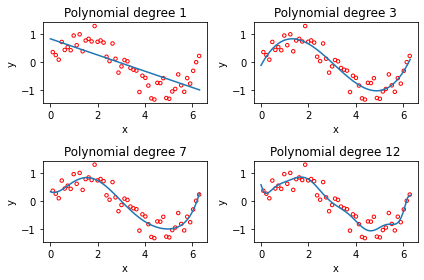

In [76]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [82]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    N = len(y)
    a = np.random.permutation(N)
    split_ind = int(N*ratio)
    a_train = a[:split_ind]
    a_test = a[split_ind:]
    return x[a_train], y[a_train], x[a_test], y[a_test]


Then, test your `split_data` function below.

In [85]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)
    
    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)
    

    _, w = least_squares(y_train, x_train_poly)

    rmse_tr = compute_rmse(y_train, x_train_poly, w)
    rmse_te = compute_rmse(y_test, x_test_poly, w)
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [86]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.254
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.531
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=1.990
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=2.911


# 3 Ridge Regression
Please fill in the function below.

In [87]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    w = np.linalg.solve(tx.T @ tx + lambda_ * np.eye(tx.shape[1]), tx.T @ y)
    e = y - tx@w
    mse = np.squeeze(e.T @ e) / (2*len(y))
    return mse, w

In [104]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 10, 50)
    
    x_train, y_train, x_test, y_test = split_data(x, y, ratio, seed)

    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)
    
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        loss, w = ridge_regression(y_train, x_train_poly, lambda_)
        rmse_tr.append(compute_rmse(y_train, x_train_poly, w))
        rmse_te.append(compute_rmse(y_test, x_test_poly, w))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.006, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.012, Training RMSE=0.228, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.023, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.047, 

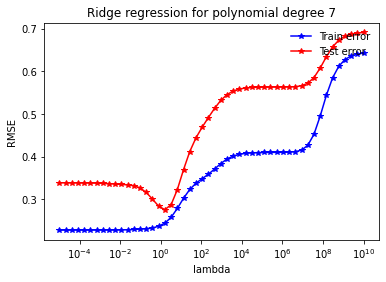

In [105]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)